<a href="https://colab.research.google.com/github/harryypham/MyMLPractice/blob/main/VQVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader

%matplotlib inline

In [51]:
trainset = torchvision.datasets.CIFAR10(root="data", train=True, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))

testset = torchvision.datasets.CIFAR10(root="data", train=False, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))

batch_size = 32


trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

data_variance = np.var(trainset.data / 255.0)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
print(data_variance)

0.06328692405746414


In [94]:
class ResidualBlock(nn.Module):
  def __init__(self, in_dims, hidden_dims):
    super(ResidualBlock, self).__init__()
    self.block = nn.Sequential(
        nn.ReLU(),
        nn.Conv2d(in_dims, hidden_dims, 3, 1, 1, bias=False),
        nn.ReLU(),
        nn.Conv2d(hidden_dims, in_dims, 1, 1, bias=False)
    )

  def forward(self, x):
    return self.block(x) + x

class ResidualStack(nn.Module):
  def __init__(self, in_dims, hidden_dims, num_layers):
    super(ResidualStack, self).__init__()
    self.stack = self._make_layers(in_dims, hidden_dims, num_layers)


  def _make_layers(self, in_dims, hidden_dims, num_layers):
    ls = []
    for i in range(num_layers):
      ls.append(ResidualBlock(in_dims, hidden_dims))

    return nn.Sequential(*ls)

  def forward(self, x):
    return F.relu(self.stack(x))

class Encoder(nn.Module):
  def __init__(self, in_dims, hidden_dims, residual_hidden_dims=64):
    super(Encoder, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_dims, hidden_dims//2, 4, 2, 1),
        nn.ReLU(),
        nn.Conv2d(hidden_dims//2, hidden_dims, 4, 2, 1),
        nn.ReLU(),
        nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1),
        nn.ReLU()
    )
    self.layer2 = ResidualStack(hidden_dims, residual_hidden_dims, 2)

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    return x

class Decoder(nn.Module):
  def __init__(self, in_dims, hidden_dims, residual_hidden_dims=64):
    super(Decoder, self).__init__()
    self.conv_1 = nn.Conv2d(in_dims, hidden_dims, 3, 1, 1)
    self.layer1 = ResidualStack(hidden_dims, residual_hidden_dims, 2)
    self.layer2 = nn.Sequential(
        nn.ConvTranspose2d(hidden_dims, hidden_dims//2, 4, 2, 1),
        nn.ReLU(),
        nn.ConvTranspose2d(hidden_dims//2, 3, 4, 2, 1)
    )

  def forward(self, x):
    x = F.relu(self.conv_1(x))
    x = self.layer1(x)
    x = self.layer2(x)
    return x



In [100]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Encoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)
        self._residual_stack = ResidualStack(num_hiddens, num_residual_hiddens, 2)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = F.relu(x)

        x = self._conv_2(x)

        x = self._residual_stack(x)
        return self._conv_3(x)

class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Decoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)

        self._residual_stack = ResidualStack(num_hiddens, num_residual_hiddens, 2)

        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens,
                                                out_channels=num_hiddens//2,
                                                kernel_size=4,
                                                stride=2, padding=1)

        self._conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens//2,
                                                out_channels=3,
                                                kernel_size=4,
                                                stride=2, padding=1)

    def forward(self, inputs):
        x = self._conv_1(inputs)

        x = self._residual_stack(x)

        x = self._conv_trans_1(x)
        x = F.relu(x)

        return self._conv_trans_2(x)

In [32]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)

        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss

        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # convert quantized from BHWC -> BCHW
        return quantized.permute(0, 3, 1, 2).contiguous(), loss

In [33]:
class VQEmbedding(nn.Module):
  def __init__(self, emb_size, emb_dims, beta=0.25):
    super().__init__()
    self.emb_size = emb_size
    self.emb_dims = emb_dims
    self.beta = beta
    self.embedding = nn.Embedding(emb_size, emb_dims)
    self.embedding.weight.data.uniform_(-1./emb_size, 1./emb_size)

  def forward(self, x):
    # Current: https://github.com/zalandoresearch/pytorch-vq-vae/blob/master/vq-vae.ipynb
    # https://juliusruseckas.github.io/ml/vq-vae.html
    # Work out how the formula to calculate the distance work
    x = x.permute(0, 2, 3, 1).contiguous()
    input_shape = x.shape
    flatten_x = x.view(-1, self.emb_dims)

    distances = torch.sum(flatten_x ** 2, dim=1, keepdim=True) \
                + torch.sum(self.embedding.weight**2, dim=1) \
                - 2 * torch.matmul(flatten_x, self.embedding.weight.t())

    indices = torch.argmin(distances, dim=1).unsqueeze(1)
    encodings = torch.zeros(indices.shape[0], self.emb_size).to(device)
    encodings.scatter_(1, indices, 1)


    # Quantize and unflatten
    quantized = torch.matmul(encodings, self.embedding.weight).view(input_shape)

    e_latent_loss = F.mse_loss(quantized.detach(), x)
    q_latent_loss = F.mse_loss(quantized, x.detach())
    loss = q_latent_loss + self.beta * e_latent_loss

    # Make the gradient with respect to inputs be equal to the gradient with respect to quantized latents (cool trick!)
    quantized = x + (quantized - x).detach()
    quantized = quantized.permute(0, 3, 1, 2).contiguous()

    return quantized, loss

In [86]:
class VQVAE(nn.Module):
  def __init__(self, emb_size, emb_dims, hidden_dims, residual_hidden_dims):
    super().__init__()
    self.encoder = Encoder(3, hidden_dims, residual_hidden_dims)
    self.pre_vq_conv = nn.Conv2d(hidden_dims, emb_dims, 1, 1)
    self.decoder = Decoder(emb_dims, hidden_dims, residual_hidden_dims)
    self.vq = VQEmbedding(emb_size, emb_dims)
    # self.vq = VectorQuantizer(emb_size, emb_dims, 0.25)

  def forward(self, x):
    z_e = self.encoder(x)
    z_e = self.pre_vq_conv(z_e)
    z_q, loss = self.vq(z_e)
    x_recon = self.decoder(z_q)
    return x_recon, loss

In [90]:
num_hiddens = 128
num_residual_hiddens = 32
embedding_dim = 64
num_embeddings = 512
num_epochs = 10
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [102]:
model = VQVAE(num_embeddings, embedding_dim, num_hiddens, num_residual_hiddens).to(device)
print(sum([p.numel() for p in model.parameters()]))

694851


In [103]:
optimizer = optim.Adam(model.parameters(), lr=2e-4)

loss_history = []

model.train()
for epoch in range(num_epochs):
  train_loss = 0
  print(f"Epoch {epoch+1}")
  for batch_idx, (inputs, _) in enumerate(trainloader):
    inputs = inputs.to(device)
    optimizer.zero_grad()

    outputs, vq_loss = model(inputs)
    loss = vq_loss + (F.mse_loss(outputs, inputs) / data_variance)
    loss.backward()

    optimizer.step()
    loss_history.append(loss.item())
    train_loss += loss.item()

    if (not batch_idx % 200) and batch_idx != 0:
            print ('Batch %03d | Cost: %.6f'
                  %(batch_idx, train_loss/(batch_idx+1)))



Epoch 1
Batch 200 | Cost: 200.650917
Batch 400 | Cost: 194.818681
Batch 600 | Cost: 158.734626
Batch 800 | Cost: 128.093931
Batch 1000 | Cost: 106.969086
Batch 1200 | Cost: 93.718829
Batch 1400 | Cost: 85.180442
Epoch 2
Batch 200 | Cost: 6.901402
Batch 400 | Cost: 5.176212
Batch 600 | Cost: 4.367295
Batch 800 | Cost: 3.821436
Batch 1000 | Cost: 3.428387
Batch 1200 | Cost: 3.117609
Batch 1400 | Cost: 2.846492
Epoch 3
Batch 200 | Cost: 0.812327
Batch 400 | Cost: 0.743320
Batch 600 | Cost: 0.691479
Batch 800 | Cost: 0.648742
Batch 1000 | Cost: 0.611452
Batch 1200 | Cost: 0.583629
Batch 1400 | Cost: 0.559046
Epoch 4
Batch 200 | Cost: 0.374333
Batch 400 | Cost: 0.364457
Batch 600 | Cost: 0.359887
Batch 800 | Cost: 0.356132
Batch 1000 | Cost: 0.350885
Batch 1200 | Cost: 0.346340
Batch 1400 | Cost: 0.342965
Epoch 5
Batch 200 | Cost: 0.326457
Batch 400 | Cost: 0.331434
Batch 600 | Cost: 0.332830
Batch 800 | Cost: 0.332329
Batch 1000 | Cost: 0.331816
Batch 1200 | Cost: 0.330656
Batch 1400 | Cos

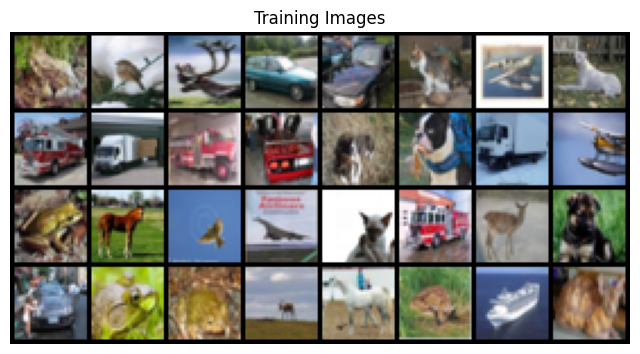

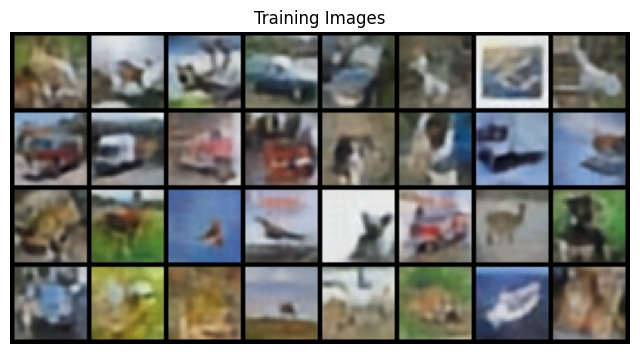

In [104]:
def imshow(images):
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Training Images")
    plt.imshow(np.transpose(vutils.make_grid(images[:], padding=2, normalize=True).cpu(),(1,2,0)))
    plt.show()

testiter = iter(testloader)
images, _ = next(testiter)
imshow(images)
images = images.to(device)
recon_images, _ = model(images)
imshow(recon_images)